---

title: "无限高斯混合模型"
date: 2024-12-12T14:00:00-06:00
author: 郝鸿涛
slug: igmm
draft: false
toc: true
tags: 统计
---

## 概念讲解

无限高斯混合模型 (Infinite Gaussian Mixture Model, IGMM) 是 [高斯混合模型](/cn/2024/11/21/gmm/) 的延伸。它处理这样的情况：我们不知道有几个簇 (cluster) 。这时候就不能用 GMM 中用到的 E-M 算法了。

解决方法是我们假设有无数个簇。设数据点 $x_i$ 所属的簇为 $z_i = k$。其中 $k$ 表示一个具体的簇。我们假设每个簇的数据符合正态分布，$\mathcal{N}(\mu_k, \sigma_k^2)$。那我们最后想得到的是两个概率分布：

1. 对于一个数据点 $x_i$，我们想知道该数据点属于某一个簇的概率，$P(z_i = k|x_i)$，这是一个离散分布。
2. 已知某一簇所包含的数据点集合 $X_k = \{x_i|z_i = k\}$，我们想知道该簇参数的后验分布，即不同 $\mu_k$ 与 $\sigma_k^2$ 的概率分布，$P(\mu_k, \sigma_k^2|X_k)$，这是一个连续分布。

为了计算这两个概率，我们需要拿出「贝叶斯公式」这个杀手锏：

\begin{equation}
P(z_i = k|x_i) \propto P(z_i = k) \cdot P(x_i|z_i = k) =  P(z_i = k) \cdot P(x_i|\mu_k, \sigma_k^2) \tag{1}
\end{equation}

\begin{equation}
P(\mu_k, \sigma_k^2|X_k) \propto P(\mu_k, \sigma_k^2) \cdot \prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)\tag{2}
\end{equation}

对于公式 (1):

$ P(z_i = k)$ 是簇的先验概率。也就是说，我们在没有任何信息的情况下，如何推断一个数据点 $x_i$ 属于哪个簇。

$P(x_i|z_i = k)$ 表示在 $x_i$ 属于簇 $k$ 的条件下，数据点的似然。对于高斯分布，这个似然概率就是横坐标某一个 $x$ 所对应的密度值 (PDF)。也就是说，$P(x_i|z_i = k) = P(x_i|\mu_k, \sigma_k^2)$

对于公式 (2):

最后我们想得到的 $P(\mu_k, \sigma_k^2|X_k)$ 是关于给定 $X_k$ 这条信息后，我们对于该簇参数的认识。那我们选择什么分布来描述我们对参数的认识呢？

我们先看簇均值 $\mu_k$，可选的分布很多，比如正态分布、 T 分布、拉普拉斯分布等。$\sigma_k^2$ 的话，我们要确保 $\sigma_k^2 \ge 0$，可选的分布也有很多，比如伽马分布、逆伽马分布、卡方分布、对数正态分布、指数分布等。都可以保证结果（分布的随机变量）非负。

另外，我们需要注意的是，$P(\mu_k, \sigma_k^2|X_k)$ 是一个联合概率，因为 $\mu_k$ 与 $\sigma_k^2$ 是关联的。当 $\sigma_k^2$ 比较小时，我们对均值的不确定性就比较小。因此，后验分布也需要描述它们的关系。

$\prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)$ 是将多个正态分布密度函数相乘。但是在具体计算时，我们是逐点计算：

\begin{equation}
P(\mu_k, \sigma_k^2|x_i, z_i = k) \propto P(\mu_k, \sigma_k^2) \cdot P(x_i|\mu_k, \sigma_k^2)\tag{3}
\end{equation}

对 $X_k$ 中的所有点算一遍，最后的结果就是 $P(\mu_k, \sigma_k^2|X_k)$

这里为什么逐点计算的结果和连乘的结果一样？设想，对于集合 $X_k$ 中第一个数据点，$P(\mu_k, \sigma_k^2) \cdot P(x_1|\mu_k, \sigma_k^2)$ 得到的后验是计算 $x_2$ 时的先验。所以逐点计算和该簇所有点一起计算，结果是一样的。

现在的问题是，我们如何选择均值和方差的分布，以满足上面的两个个要求：(1) 符合实际。也就是从上面列出的可选分布中选。(2) 是一个联合概率。另外，最好符合第三个要求 （3）计算方便。

科学家发现一个很巧的事情：如果先验概率我们选择用正态分布描述均值，用逆伽马分布描述方差，那么和 $\prod_{x_i \in X_k} P(x_i|\mu_k, \sigma_k^2)$ 相乘之后，最后得到的分布和先验分布形式相同，也是「正态-逆伽马分布」 ([Normal-Inverse-Gamma Distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution))。这就大大简化了计算量，所以我们选择用正态分布描述均值，用逆伽马分布描述方差。其中，数据决定逆伽马函数，而逆伽马函数决定了正态分布。这样一来，上面的三个要求全都满足了。

更多这种很巧的案例可以参考「[共轭先验](https://en.wikipedia.org/wiki/Conjugate_prior)」。

## 具体的计算过程

我们来讲一下具体怎么计算。我们是逐点计算的，也就是对每一个数据点进行遍历。

### 公式 (3)

我们先来看公式 (3)。

假设当前的先验 $P(\mu_k, \sigma_k^2)$ 是正态-逆伽马分布：

$$\sigma^2 \sim \text{InvGamma}(\alpha_0, \beta_0)$$

$$\mu|\sigma^2 \sim \mathcal{N}(\mu_0, \frac{\sigma^2}{\kappa_0})$$

其中：

- $\alpha_0, \beta_0$：控制方差分布的形状
- $\mu_0$：均值的先验均值
- $\kappa_0$：对均值先验的确信程度

属于某簇 $k$ 的一个新数据点 $x_i$ 的似然函数：

$$P(x_i|\mu_k, \sigma_k^2) = \frac{1}{\sqrt{2\pi\sigma_k^2}}\exp\left( -\frac{(x_i - \mu_k)^2}{2\sigma_k^2} \right)$$

需要注意的是，$\mu_k$ 和 $\sigma_k^2$ 是该簇参数当前的后验分布，即 $P(\mu_k, \sigma_k^2|X_k)$。也就是说，它们本身也是一个分布，而不是一个确定的值。对于该簇的第一个数据点，$\mu_k$ 和 $\sigma_k^2$ 就是先验分布。

$\mu_k$ 和 $\sigma_k^2$ 是分布，而非具体的值，但是 $P(x_i|\mu_k, \sigma_k^2)$ 确确实实是一个具体的值，怎么办？我们需要考虑所有的 $\mu$ 和 $\sigma^2$，然后取加权平均。权重就是每个  $\mu$ 和 $\sigma^2$ 在$P(\mu_k, \sigma_k^2|X_k)$ 中的密度值：

$$P(x_i|\mu_k, \sigma_k^2) = \int_{\mu} \int_{\sigma^2} P(x_i|\mu, \sigma^2) \cdot P(\mu, \sigma^2|X_k) \cdot d\mu \cdot d\sigma^2$$

这个双重积分还要在乘上 $P(\mu_k, \sigma_k^2)$ 这个先验分布，那真是「难算他妈给难算开门，难算到家了」。

不过好在数学家已经提前算好了：如果 $P(\mu_k, \sigma_k^2)$ 用正态-逆伽马分布的话，带入上面的公式，得到的结果依然是一个正态-逆伽马分布，这就是「共轭先验」。

这样一来，我们直接根据这些先辈得出的「共轭先验」的性质就可以更新正态-逆伽马分布的参数：

- $\kappa_n = \kappa_0 + n$
- $\mu_n = \frac{\kappa_0\mu_0 + n \bar{x}}{\kappa_n}$
- $\alpha_n = \alpha_0 + \frac{n}{2}$
- $\beta_n = \beta_0 + \frac{1}{2}\sum(x_i - \bar{x})^2 + \frac{\kappa_0n(\bar{x}-\mu_0)^2}{2\kappa_n}$

也就是说，我们的后验分布为：

$$\sigma_\text{post}^2 \sim \text{InvGamma}(\alpha_n, \beta_n)$$

$$\mu_\text{post}|\sigma_\text{post}^2 \sim \mathcal{N}(\mu_n, \frac{\sigma_\text{post}^2}{\kappa_n})$$

这里有两点需要格外注意，第一点，上面给出的公式，如果是逐点更新 (incremental updating) 后验分布参数的话，那么 $n = 1, \bar{x} = x_i$。 如果批量更新 (batch updating)，也就是把所有的数据点都算完，我们知道了每个簇包含的所有点之后再一起更新参数，那 $n$ 是该簇总共有多少个数据点，$\bar{x}$ 是这些数据的均值。通常来说，为了计算方便，我们更倾向用批量更新。

这就带来了第二个问题：我们并不知道这个数据点具体属于哪一个簇。根据公式 (1)，任一数据点的簇所属是一个分布，即 $P(z_i = k|x_i)$，而非一定值。这么一来，$n$，即 $x_i$ 所对应的簇所包含的数据点数量，就没办法算了。

我们主要有两种处理方法：

1. 最大后验估计 (Maximum A Posteriori, MAP)。也就是找到 $P(z_i = k|x_i)$ 最大时对应的 $k^*$。

2. 随机采样。从 $P(z_i = k|x_i)$ 按照权重随机采样，得到一个具体的 $k$。

我们通常选择第二种方法，这样可以保留不确定性。

### 公式 (1)

但是在计算公式 (1) 的时候，我们就没有那么幸运了。如果精确计算的话，我们必须用上面的双重积分公式来计算 $P(x_i|\mu_k, \sigma_k^2)$。这种计算很复杂，为了简化，我们最好让 $\mu_k$ 和 $\sigma_k^2$ 是一个具体的值，而不是分布，这样的话，直接带入正态分布的密度函数就好了。那如何找到这两个具体的值？

我们知道 $\mu_k, \sigma_k^2 \sim P(\mu_k, \sigma_k^2|X_k)$，那我们可以

1. 随机采样。从该后验分布中，随机采多个值，计算 $P(x_i|\mu_k, \sigma_k^2)$，然后取平均值：

$$P(x_i|\mu_k, \sigma_k^2) = \frac{1}{S} \sum_{s=1}^S P(x_i|\mu_k^{(s)}, \sigma_k^{2(s)})$$

其中 $S$ 是采样次数。这种方法通常用 Gibbs sampling 或者 MCMC 方法实现。这里我们不展开讲。

2. 最大后验估计 (Maximum A Posteriori, MAP)，也就是取密度最高的值。

一般情况下，我们选择随机采样以保留不确定性。

对于 $P(z_i = k)$，一般的教材中都直接用 Dirichlet Process 或者 Chinese Restaurant Process，但我们为了简单，不假设有无数个簇。而是说：我们知道可能是两个簇，不确定，但肯定不会多于 10 个簇。那我们就用均匀分布 Uniform Distribution。当然也可以可以用多项分布，Multinomial Distribution 等。因为数据如果够多，先验分布没那么重要，我们还是用均匀分布来做简单计算。

### 总结

我们来总结一下计算的流程，也就是具体的算法。

我们是逐点计算：遍历每一个数据点。对于公式 (2)，根据共轭先验，我们使用该簇所包含的数据点数量 $n$ 以及这些数据点的均值 $\bar{x}$， 就可以直接更新簇参数后验分布 $P(\mu_k,\sigma_k^2|X_k)$。但是由于给定一个数据点的簇分布 $P(z_i=k|x_i)$ 非具体值，我们选择单次随机采样，得到一个具体的 $k$。这样对于所有的数据点遍历之后，我们就知道了每个簇的 $n$ 与 $\bar{x}$。

公式 (1) 中，我们为了绕开双重积分这种高强度计算，选择对参数后验分布 $P(\mu_k,\sigma_k^2|X_k)$ 进行多次随机采样，然后取加权平均值，得到 $\mu_k$ 和 $\sigma_k^2$ 的估值。然后将数据点 $x_i$ 带入 $\mathcal{N}(\mu, \sigma^2)$ 的概率密度函数 (PDF) 中，得到 $P(x_i|\mu_k, \sigma_k^2)$ 的估值。这个过程要对每一个 $k$ 进行，这样才能得到我们想要的离散分布。

## 开工

Talk is cheap, show me the code.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.stats import invgamma
import time
from collections import defaultdict
from numba import jit

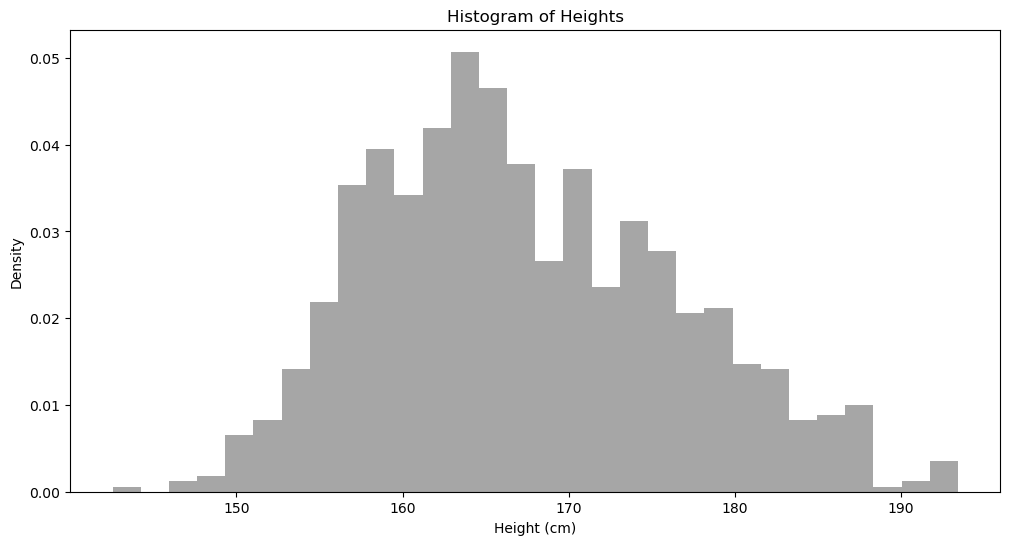

In [3]:
#|code-fold:true
np.random.seed(42)
n_female = 600
mu_female = 162
sd_female = 6
n_male = 1000 - n_female
mu_male = 175
sd_male = 7

female_heights = np.random.normal(mu_female, sd_female, n_female)
male_heights = np.random.normal(mu_male, sd_male, n_male)
heights = np.concatenate([female_heights, male_heights])
np.random.shuffle(heights)
data = heights.copy()

plt.figure(figsize=(12, 6))
plt.hist(data, bins = 30, density=True, alpha=0.7, color='gray')
plt.title('Histogram of Heights')
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.show()

In [ ]:
# setting
iterations = 2
nclusters = 10
nsampling = 10

# history of P(z_i=k|x_i)
p1s = []
# history of P(mu_k, sigma_k|X_k)
params = []

# Initialize parameters for each cluster
cluster_params = []
data_min, data_max = min(data), max(data)
for _ in range(nclusters):
    mu0 = np.random.uniform(data_min, data_max)  
    kappa0 = 1
    alpha0 = 2  
    beta0 = 1
    cluster_params.append({
        'mu': mu0,
        'kappa': kappa0,
        'alpha': alpha0,
        'beta': beta0
    })

start_time = time.time()
for it in range(iterations):
    # length will be the length of data
    # if assignments = [0] means the first data point belongs to the first cluster
    assignments = []

    for d in data:
        # Step 1: Calculate P(z_i = k | x_i)
        p1 = []
        # for each cluster, sample and 
        # get weighted average of P(x_i|mu_k, sigma_k^2)
        for k in range(nclusters):
            mus = []
            sigmas = []
            for _ in range(nsampling):
                sigma2 = invgamma.rvs(
                    cluster_params[k]['alpha'], 
                    scale = cluster_params[k]['beta']
                )
                sigma = np.sqrt(sigma2)
                mu = norm.rvs(
                    cluster_params[k]["mu"], 
                    sigma/np.sqrt(cluster_params[k]['kappa'])
                )
                mus.append(mu)
                sigmas.append(sigma)
            
            # norm.pdf() result is too small, use LogSumExp to escape underflow
            log_likelihoods = [norm.logpdf(
                d, mu, sigma) for mu, sigma in zip(mus, sigmas)]
            max_log_likelihood = np.max(log_likelihoods)
            log_sum_exp = max_log_likelihood + np.log(
                np.sum(np.exp(log_likelihoods - max_log_likelihood)))
            average_likelihood = np.exp(log_sum_exp)/len(log_likelihoods)
            p1.append(average_likelihood)

        # Step 2: Assign data point to a cluster
        probs = np.array(p1)
        if np.sum(probs) == 0:
            probs = np.ones(nclusters)/nclusters
        else:
            probs = probs / np.sum(probs)
        
        # 0-9
        choice = np.random.choice(nclusters, p=probs)
        assignments.append(choice)

    # Step 3: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k in range(nclusters):
        cluster_data_idx = [i for i, val in enumerate(assignments) if val == k]
        cluster_data = data[cluster_data_idx]
        n = len(cluster_data)
        if n == 0:
            # if cluster is empty, no need to calculate below
            # move on to the next k
            continue
        x_bar = np.mean(cluster_data)
        k_params = cluster_params[k]
        kappa_n = k_params['kappa'] + n
        mu_n = (k_params['kappa'] * k_params['mu'] + n * x_bar) / kappa_n
        alpha_n = k_params['alpha'] + 0.5 * n
        beta_n = k_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
            k_params['kappa'] * n * (x_bar - k_params['mu'])**2) / (2 * kappa_n)
            
        cluster_params[k] = {
            'mu': mu_n,
            "kappa": kappa_n,
            "alpha": alpha_n,
            "beta": beta_n
        }
    
    # keep data from this iteration 
    if (it + 1)%1 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
    p1s.append(p1.copy())
    params.append([cluster_params[k] for k in range(nclusters)])

Iteration 10 completed! Time elapsed: 59.55s


In [8]:
#|code-fold:true

def extract_cluster_means_and_variances(params, nclusters):
    """
    Extract cluster means and variances over iterations from parameter history.
    
    Args:
        params (list): A list of cluster parameters for each iteration.
        nclusters (int): Number of clusters.

    Returns:
        cluster_means (dict): Mean values for each cluster across iterations.
        cluster_variances (dict): Variance values for each cluster across iterations.
    """
    iterations = len(params)  # Number of iterations
    cluster_means = {k: [] for k in range(nclusters)}
    cluster_variances = {k: [] for k in range(nclusters)}

    # Extract means and variances for each cluster
    for it in range(iterations):
        for k in range(nclusters):
            cluster_means[k].append(params[it][k]['mu'])
            cluster_variances[k].append(1 / params[it][k]['alpha'])  # Approximation for variance

    return cluster_means, cluster_variances

def plot_cluster_means(cluster_means, iterations):
    """
    Plot the convergence of cluster means over iterations.

    Args:
        cluster_means (dict): Mean values for each cluster across iterations.
        iterations (int): Total number of iterations.
    """
    plt.figure(figsize=(12, 6))
    for k, means in cluster_means.items():
        plt.plot(range(iterations), means, label=f"Cluster {k} Mean")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster Mean (μ)")
    plt.title("Cluster Mean Convergence")
    plt.legend()
    plt.show()

def plot_cluster_variances(cluster_variances, iterations):
    """
    Plot the convergence of cluster variances over iterations.

    Args:
        cluster_variances (dict): Variance values for each cluster across iterations.
        iterations (int): Total number of iterations.
    """
    plt.figure(figsize=(12, 6))
    for k, variances in cluster_variances.items():
        plt.plot(range(iterations), variances, label=f"Cluster {k} Variance")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster Variance (σ²)")
    plt.title("Cluster Variance Convergence")
    plt.legend()
    plt.show()

# Step 2: Bar chart for cluster sizes
def plot_cluster_sizes(assignments):
    cluster_sizes = np.bincount(assignments)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
    plt.title("Cluster Sizes")
    plt.xlabel("Cluster Index")
    plt.ylabel("Number of Points")
    plt.show()

# Step 3: Line plot for likelihood progression
def plot_likelihood_progression(p1s):
    avg_likelihood = [np.mean(p) for p in p1s]
    plt.figure(figsize=(10, 5))
    plt.plot(avg_likelihood, marker='o')
    plt.title("Likelihood Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Average Likelihood")
    plt.grid()
    plt.show()

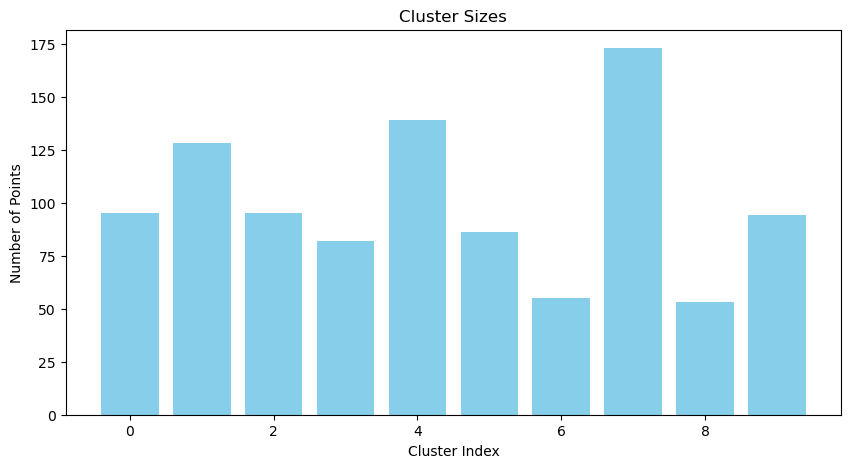

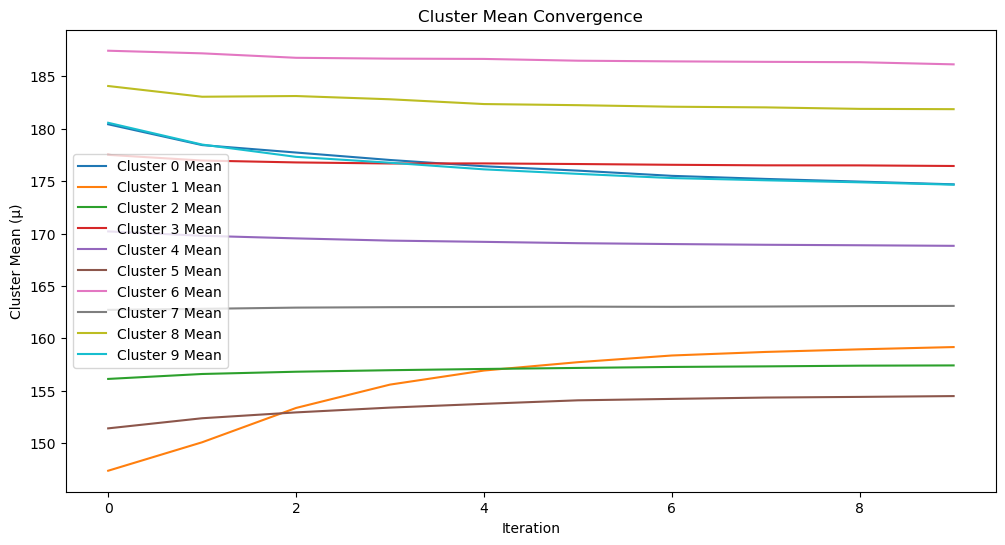

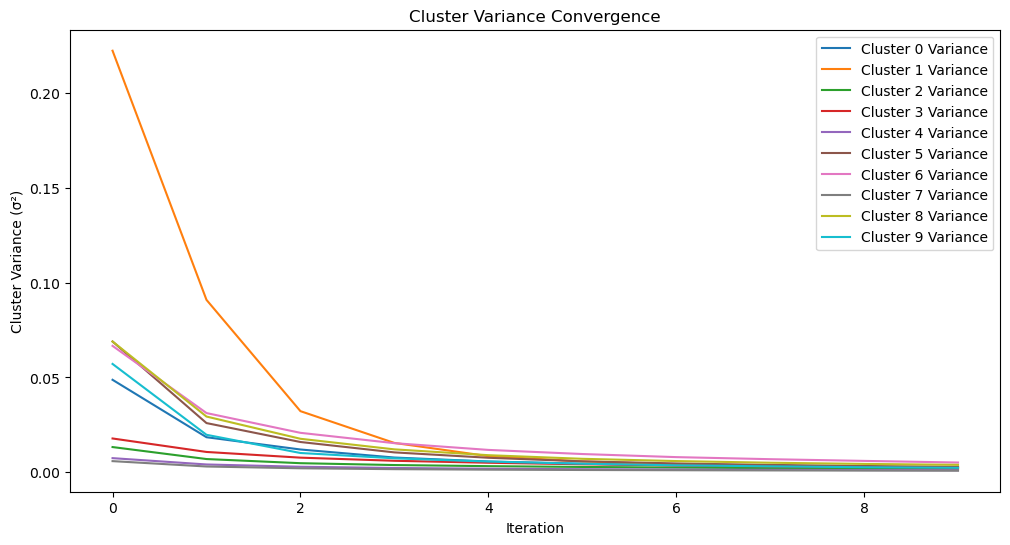

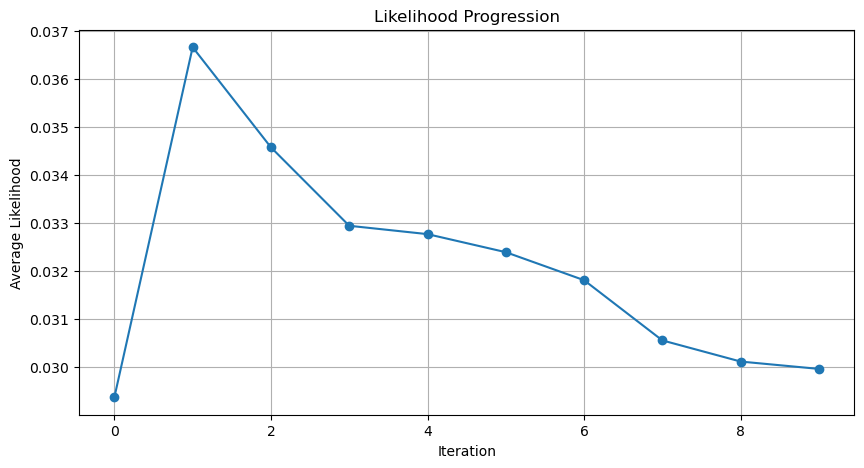

In [6]:
plot_cluster_sizes(assignments)

# Extract cluster means and variances
cluster_means, cluster_variances = extract_cluster_means_and_variances(params, nclusters)
# Plot cluster means
plot_cluster_means(cluster_means, len(params))
# Plot cluster variances
plot_cluster_variances(cluster_variances, len(params))

plot_likelihood_progression(p1s)

### 优化

我们看到，我们的算法非常慢。下面我尝试通过「向量运算」的方式进行优化:

1. 把 `[norm.logpdf(d, mu, sigma) for mu, sigma in zip(mus, sigmas)]` 变成下面的 `calculate_log_likelihood(d, mus, sigmas)`。这样我们就避免了 for loop。

2. 我们是逐点计算 $P(\mu_k, \sigma^2_k|X_k)$，这本身没问题，但是我们没必要逐点对每个簇的参数，即 $\mu$ 与 $\sigma^2_k$ 进行采样。这是因为，采样由每个簇的参数后验决定，而参数后验是在每次迭代结束的时候才更新，而不是逐点更新。所以我们在每次迭代开始时、遍历每个数据点之前对 $\mu$ 与 $\sigma^2_k$ 进行采样和估值即可。

In [17]:
@jit(nopython=True)

def calculate_log_likelihood(d, mus, sigmas):
    """Vectorized log likelihood calculation with numerical stability.
    log(exp(-(x-μ)²/(2σ²)) / sqrt(2πσ²)) 
        = -(x-μ)²/(2σ²) - log(sqrt(2πσ²))
        = -(x-μ)²/(2σ²) - 0.5*log(2π) - log(σ)
    """
    log_likelihoods = -0.5 * np.log(2 * np.pi) - np.log(sigmas) - \
                      0.5 * ((d - mus) / sigmas) ** 2
    max_log_likelihood = np.max(log_likelihoods)
    log_sum_exp = max_log_likelihood + np.log(
        np.sum(np.exp(log_likelihoods - max_log_likelihood)))
    return np.exp(log_sum_exp) / len(mus)

# setting
iterations = 1000
nclusters = 10
nsampling = 10

# history of P(z_i=k|x_i)
p1s = []
# history of P(mu_k, sigma_k|X_k)
params_history = []
n_data = len(data)

# Initialize parameters for each cluster
cluster_params = {}
data_min, data_max = min(data), max(data)
for k in range(nclusters):
    mu0 = np.random.uniform(data_min, data_max)  
    kappa0 = 1
    alpha0 = 2  
    beta0 = 1
    cluster_params[k]={
        'mu': mu0,
        'kappa': kappa0,
        'alpha': alpha0,
        'beta': beta0
    }

start_time = time.time()
for it in range(iterations):
    # length will be the length of data
    # if assignments = [0] means the first data point belongs to the first cluster
    assignments = np.zeros(n_data, dtype=np.int32)

    # for each cluster, sample and get weighted average of P(x_i|mu_k, sigma_k^2)
    # we assume the first data point belongs to cluster 0
    all_mus = {}
    all_sigmas = {}
    for k, k_params in cluster_params.items():
        sigma2_samples = invgamma.rvs(
            k_params['alpha'], 
            scale = k_params['beta'],
            size = nsampling
        )
        sigma_samples = np.sqrt(sigma2_samples)
        mu_samples = norm.rvs(
            k_params["mu"], 
            sigma_samples/np.sqrt(k_params['kappa'])
        )
        all_mus[k] = mu_samples
        all_sigmas[k] = sigma_samples

    for idx, d in enumerate(data):
        # Step 1: Calculate P(z_i = k | x_i) for all existing clusters
        p1 = np.zeros(len(cluster_params))
        for k_idx, k in enumerate(cluster_params.keys()):
            p1[k_idx] = calculate_log_likelihood(d, all_mus[k], all_sigmas[k])
        
        # Step 2: Assign data point to a cluster
        if idx == 0:
            assignments[idx] = 0
            continue

        probs = np.array(p1)
        if np.sum(probs) == 0:
            probs = np.ones(nclusters)/nclusters
        else:
            probs = probs / np.sum(probs)
        
        # 0-9
        choice = np.random.choice(nclusters, p=probs)
        assignments[idx] = choice

    # Step 3: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k, k_params in cluster_params.items():
        cluster_data = data[assignments == k]
        n = len(cluster_data)

        if n> 0:
            x_bar = np.mean(cluster_data)

            kappa_n = k_params['kappa'] + n
            mu_n = (k_params['kappa'] * k_params['mu'] + n * x_bar) / kappa_n
            alpha_n = k_params['alpha'] + 0.5 * n
            beta_n = k_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
                k_params['kappa'] * n * (x_bar - k_params['mu'])**2) / (2 * kappa_n)
                
            cluster_params[k] = {
                'mu': mu_n,
                "kappa": kappa_n,
                "alpha": alpha_n,
                "beta": beta_n
            }
    
    # keep data from this iteration 
    if (it + 1)%100 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
    p1s.append(p1.copy())
    params_history.append([cluster_params[k] for k in range(nclusters)])

Iteration 100 completed! Time elapsed: 2.07s
Iteration 200 completed! Time elapsed: 3.96s
Iteration 300 completed! Time elapsed: 5.81s
Iteration 400 completed! Time elapsed: 7.67s
Iteration 500 completed! Time elapsed: 9.59s
Iteration 600 completed! Time elapsed: 11.50s
Iteration 700 completed! Time elapsed: 13.37s
Iteration 800 completed! Time elapsed: 15.26s
Iteration 900 completed! Time elapsed: 17.25s
Iteration 1000 completed! Time elapsed: 19.15s


明显快了很多。现在 1000 次迭代只需要 18 秒。

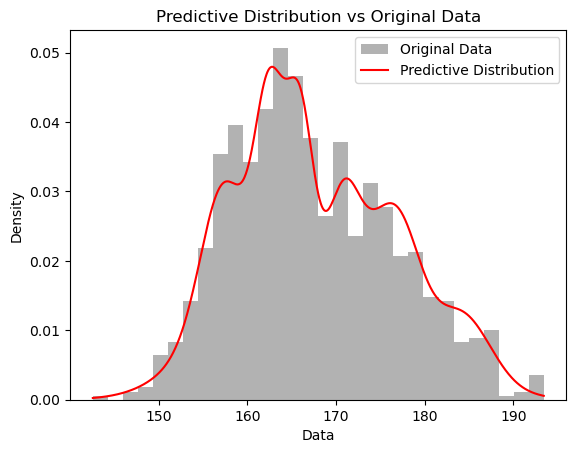

In [18]:
plot_predictive_distribution(data, cluster_params, assignments)

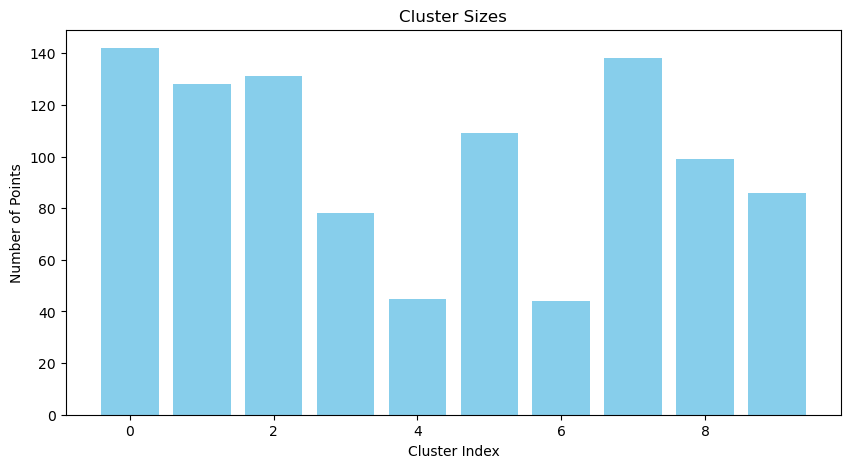

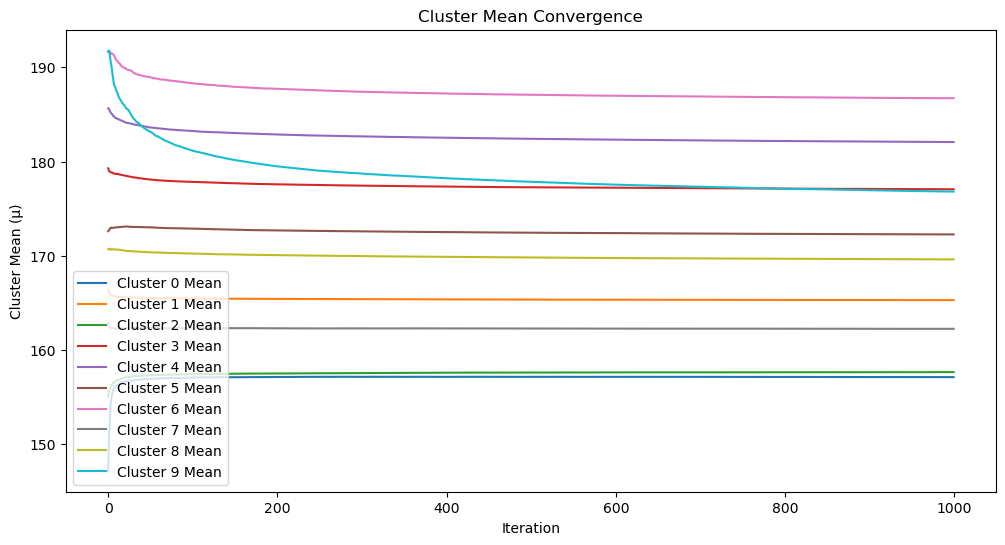

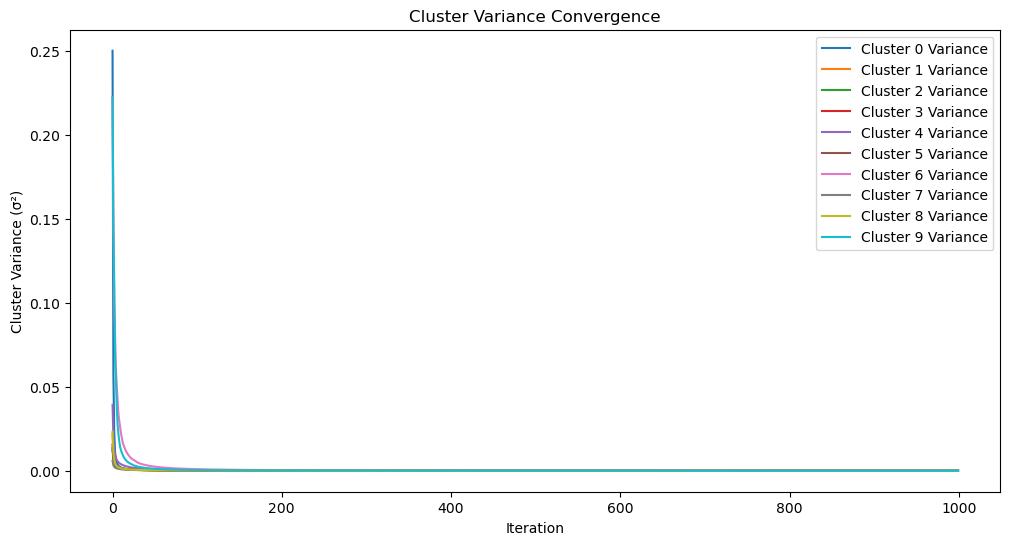

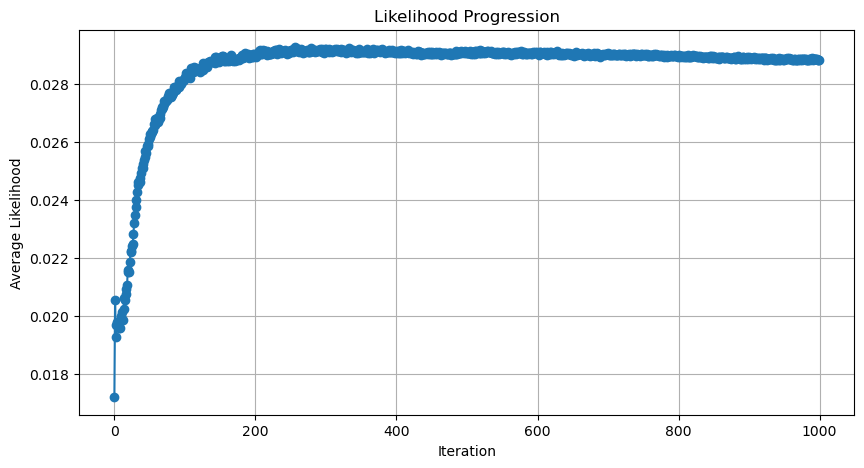

In [10]:
plot_cluster_sizes(assignments)

# Extract cluster means and variances
cluster_means, cluster_variances = extract_cluster_means_and_variances(params_history, nclusters)
# Plot cluster means
plot_cluster_means(cluster_means, len(params_history))
# Plot cluster variances
plot_cluster_variances(cluster_variances, len(params_history))

plot_likelihood_progression(p1s)

## 用 Dirichlet Process 当作先验

我们上面用的是均匀分布做先验，但是我们看到结果并不是很好。 30 次迭代之后，我们想要的数据大部分在两个簇这个结果并没有出现。这是因为，第一，我们的迭代次数不够。迭代次数够多的话，先验的选择对结果影响会很小。第二，我们的先验选择的不好，在迭代次数有限的情况下，没办法得到符合实际的后验分布。

那比较合适的先验是什么呢？Dirichlet Process。为什么？因为如果一个簇很大，那当我们有一个新的数据点，这个数据点属于这个簇的概率要大于无限个很小的簇，这个也符合贝叶斯统计的后验更新逻辑。选择 Dirichlet Process 做先验的一个明显好处是，我们不用提前设定有多少个簇，而是通过设定 `alpha` 来决定新开一个簇的概率。

完整代码如下：

Iteration 100 completed! Time elapsed: 3.99s
Iteration 100, cluster_params: {0: {'mu': 167.34327721747178, 'kappa': 29257.5, 'alpha': 14629.5, 'beta': 1222257.3115378711}, 1: {'mu': 167.30515094790482, 'kappa': 22236.5, 'alpha': 11119.0, 'beta': 918137.3003161071}, 2: {'mu': 167.3533606615272, 'kappa': 15913.5, 'alpha': 7957.5, 'beta': 668780.8759738209}, 3: {'mu': 167.2934504609624, 'kappa': 11091.5, 'alpha': 5546.5, 'beta': 469452.72894195426}, 4: {'mu': 167.3602942933849, 'kappa': 7056.5, 'alpha': 3529.0, 'beta': 296770.8044854759}, 5: {'mu': 167.56524785044448, 'kappa': 4551.5, 'alpha': 2276.5, 'beta': 189772.18623551642}, 6: {'mu': 167.34734883992397, 'kappa': 1486.5, 'alpha': 744.0, 'beta': 62959.826455405484}, 7: {'mu': 167.66211939823262, 'kappa': 638.5, 'alpha': 320.0, 'beta': 26030.14152524416}, 8: {'mu': 167.6290219534996, 'kappa': 330.5, 'alpha': 166.0, 'beta': 13597.025997200735}, 9: {'mu': 167.19614960027172, 'kappa': 62.5, 'alpha': 32.0, 'beta': 2311.781737615863}, 10: {

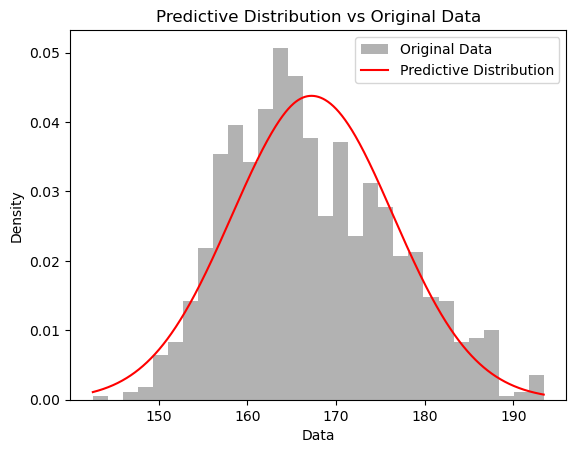

Iteration 200 completed! Time elapsed: 8.04s
Iteration 200, cluster_params: {0: {'mu': 167.32849675036968, 'kappa': 60194.5, 'alpha': 30098.0, 'beta': 2508122.4718691777}, 1: {'mu': 167.30001889394325, 'kappa': 44522.5, 'alpha': 22262.0, 'beta': 1852325.0211844554}, 2: {'mu': 167.38121746200073, 'kappa': 33165.5, 'alpha': 16583.5, 'beta': 1391968.3084415304}, 3: {'mu': 167.31828767229445, 'kappa': 19509.5, 'alpha': 9755.5, 'beta': 814809.3713091579}, 4: {'mu': 167.32893886082428, 'kappa': 13754.5, 'alpha': 6878.0, 'beta': 577589.598691296}, 5: {'mu': 167.56331022853664, 'kappa': 1125.5, 'alpha': 563.5, 'beta': 46920.52136745021}, 6: {'mu': 167.61949751107187, 'kappa': 1578.5, 'alpha': 790.0, 'beta': 68698.58597395182}, 7: {'mu': 166.97965414037697, 'kappa': 983.5, 'alpha': 492.5, 'beta': 41319.734105670876}, 8: {'mu': 169.43984424103445, 'kappa': 153.5, 'alpha': 77.5, 'beta': 6243.345671760088}, 9: {'mu': 168.52002272902163, 'kappa': 21.5, 'alpha': 11.5, 'beta': 856.4107543911787}}


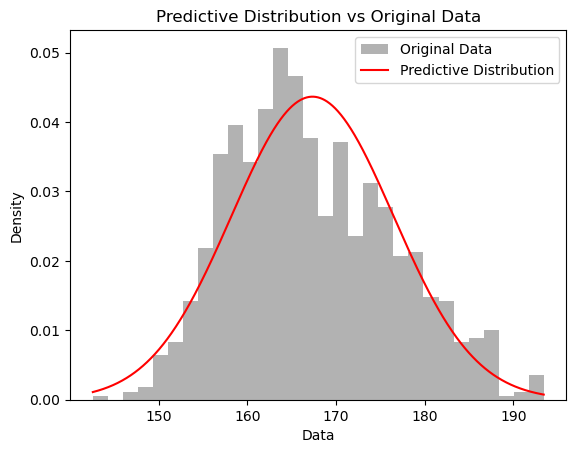

Iteration 300 completed! Time elapsed: 12.13s
Iteration 300, cluster_params: {0: {'mu': 167.3248036474094, 'kappa': 95560.5, 'alpha': 47781.0, 'beta': 3980511.5326227876}, 1: {'mu': 167.32570312469767, 'kappa': 66657.5, 'alpha': 33329.5, 'beta': 2768811.064345788}, 2: {'mu': 167.38153004734073, 'kappa': 48928.5, 'alpha': 24465.0, 'beta': 2054209.4250774828}, 3: {'mu': 167.30953545718478, 'kappa': 27952.5, 'alpha': 13977.0, 'beta': 1169714.0787472818}, 4: {'mu': 167.59932528112708, 'kappa': 4162.5, 'alpha': 2082.0, 'beta': 178652.27459651648}, 5: {'mu': 166.96578126855977, 'kappa': 2108.5, 'alpha': 1055.0, 'beta': 88681.47826202601}, 6: {'mu': 167.05171850549416, 'kappa': 1758.5, 'alpha': 880.0, 'beta': 75246.69161163819}, 7: {'mu': 167.11727104336015, 'kappa': 530.5, 'alpha': 266.0, 'beta': 22654.372468596535}, 8: {'mu': 167.29499069309716, 'kappa': 100.5, 'alpha': 51.0, 'beta': 4291.2626513126515}, 9: {'mu': 166.243199376518, 'kappa': 28.5, 'alpha': 15.0, 'beta': 1339.0499137000213}, 

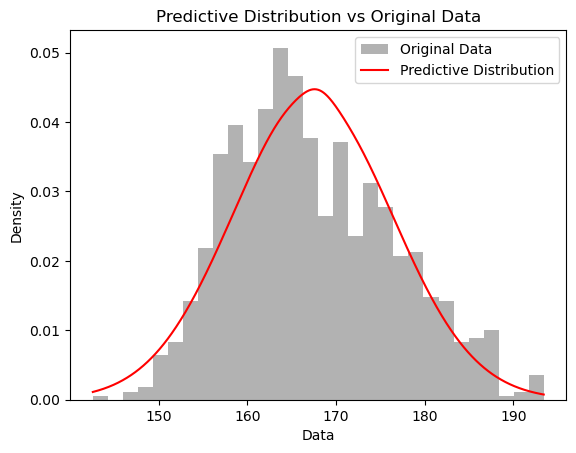

Iteration 400 completed! Time elapsed: 16.20s
Iteration 400, cluster_params: {0: {'mu': 167.31752671063654, 'kappa': 128574.5, 'alpha': 64288.0, 'beta': 5358616.75025767}, 1: {'mu': 167.32494271460286, 'kappa': 88461.5, 'alpha': 44231.5, 'beta': 3680476.074752886}, 2: {'mu': 167.37498714391705, 'kappa': 63587.5, 'alpha': 31794.5, 'beta': 2661916.1704618814}, 3: {'mu': 167.34352181355948, 'kappa': 38419.5, 'alpha': 19210.5, 'beta': 1612199.9735059969}, 4: {'mu': 167.4988565836439, 'kappa': 11152.5, 'alpha': 5577.0, 'beta': 469564.2411953411}, 5: {'mu': 167.5151960908478, 'kappa': 3434.5, 'alpha': 1718.0, 'beta': 143383.33211121178}, 6: {'mu': 167.64068454932513, 'kappa': 1788.5, 'alpha': 895.0, 'beta': 76238.79933594643}, 7: {'mu': 166.84159915040746, 'kappa': 802.5, 'alpha': 402.0, 'beta': 32899.12593386615}, 8: {'mu': 165.94575480739616, 'kappa': 42.5, 'alpha': 22.0, 'beta': 1188.0221900356405}, 9: {'mu': 165.82278848873355, 'kappa': 39.5, 'alpha': 20.5, 'beta': 1537.7132428567484}, 1

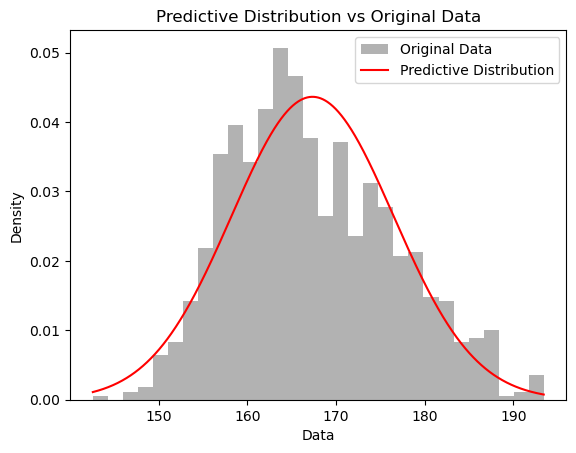

Iteration 500 completed! Time elapsed: 20.15s
Iteration 500, cluster_params: {0: {'mu': 167.3194996058705, 'kappa': 161224.5, 'alpha': 80613.0, 'beta': 6729975.901017002}, 1: {'mu': 167.33717409360418, 'kappa': 112108.5, 'alpha': 56055.0, 'beta': 4672182.48864749}, 2: {'mu': 167.36305978157645, 'kappa': 77095.5, 'alpha': 38548.5, 'beta': 3217290.371654129}, 3: {'mu': 167.3456196521474, 'kappa': 47941.5, 'alpha': 23971.5, 'beta': 2012618.0170096492}, 4: {'mu': 167.48308666846495, 'kappa': 17958.5, 'alpha': 8980.0, 'beta': 759592.7706189259}, 5: {'mu': 167.1465801585834, 'kappa': 4813.5, 'alpha': 2407.5, 'beta': 195626.63568262904}, 6: {'mu': 167.35188973181434, 'kappa': 2930.5, 'alpha': 1466.0, 'beta': 124456.54184845636}, 7: {'mu': 167.7645925056692, 'kappa': 1263.5, 'alpha': 632.5, 'beta': 55587.255130427475}, 8: {'mu': 165.83850954732847, 'kappa': 55.5, 'alpha': 28.5, 'beta': 2496.340195618731}, 9: {'mu': 168.015245765136, 'kappa': 18.5, 'alpha': 10.0, 'beta': 889.6022574885001}, 10:

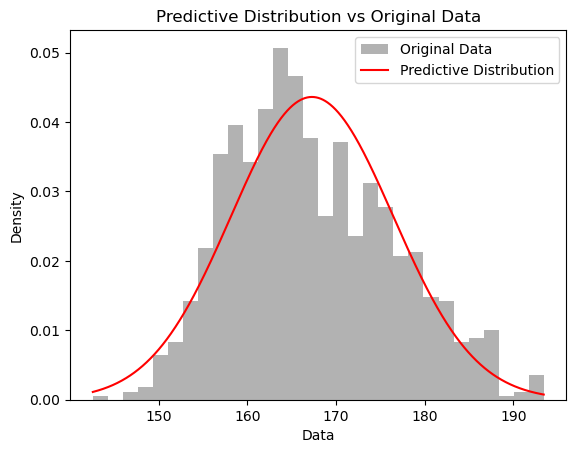

Iteration 600 completed! Time elapsed: 24.15s
Iteration 600, cluster_params: {0: {'mu': 167.31822181486433, 'kappa': 197346.5, 'alpha': 98674.0, 'beta': 8236603.574832224}, 1: {'mu': 167.33888816452523, 'kappa': 135766.5, 'alpha': 67884.0, 'beta': 5655106.078303561}, 2: {'mu': 167.37551768390185, 'kappa': 90535.5, 'alpha': 45268.5, 'beta': 3784189.8439856293}, 3: {'mu': 167.33935754725866, 'kappa': 56778.5, 'alpha': 28390.0, 'beta': 2381750.1701449025}, 4: {'mu': 167.47282149713476, 'kappa': 23419.5, 'alpha': 11710.5, 'beta': 990533.182568345}, 5: {'mu': 167.2182456884703, 'kappa': 8683.5, 'alpha': 4342.5, 'beta': 358640.2411377893}, 6: {'mu': 167.36266731775385, 'kappa': 2293.5, 'alpha': 1147.5, 'beta': 93234.56054498297}, 7: {'mu': 167.5593633046789, 'kappa': 386.5, 'alpha': 194.0, 'beta': 15606.251265941122}, 8: {'mu': 166.42362882312185, 'kappa': 125.5, 'alpha': 63.5, 'beta': 5256.720108227313}, 9: {'mu': 167.7399999818518, 'kappa': 64.5, 'alpha': 33.0, 'beta': 2352.8043877432037},

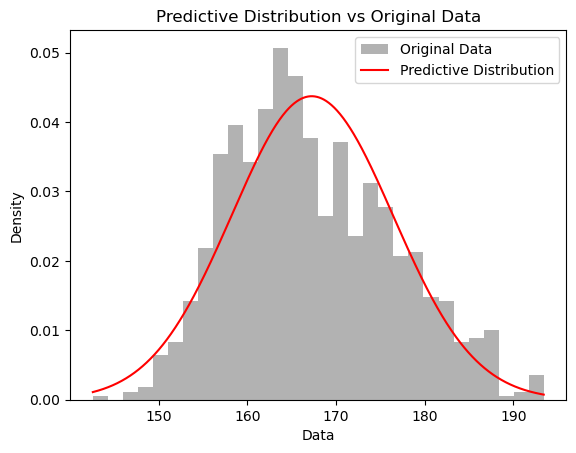

Iteration 700 completed! Time elapsed: 28.12s
Iteration 700, cluster_params: {0: {'mu': 167.31986537907255, 'kappa': 228248.5, 'alpha': 114125.0, 'beta': 9534661.161267275}, 1: {'mu': 167.33988957337374, 'kappa': 157139.5, 'alpha': 78570.5, 'beta': 6547999.318143812}, 2: {'mu': 167.3677468008146, 'kappa': 108060.5, 'alpha': 54031.0, 'beta': 4517548.085442384}, 3: {'mu': 167.34624823277267, 'kappa': 67331.5, 'alpha': 33666.5, 'beta': 2824790.224726122}, 4: {'mu': 167.41772375808836, 'kappa': 29984.5, 'alpha': 14993.0, 'beta': 1266622.2536396852}, 5: {'mu': 167.2983828088362, 'kappa': 13715.5, 'alpha': 6858.5, 'beta': 563234.4917108454}, 6: {'mu': 167.59718665848746, 'kappa': 231.5, 'alpha': 116.5, 'beta': 9997.69238474496}, 7: {'mu': 166.87554471206846, 'kappa': 200.5, 'alpha': 101.0, 'beta': 7781.152143686919}, 8: {'mu': 167.93606022378088, 'kappa': 26.5, 'alpha': 14.0, 'beta': 956.3596978685318}, 9: {'mu': 167.75544887689526, 'kappa': 99.5, 'alpha': 50.5, 'beta': 3977.0012088671037}, 

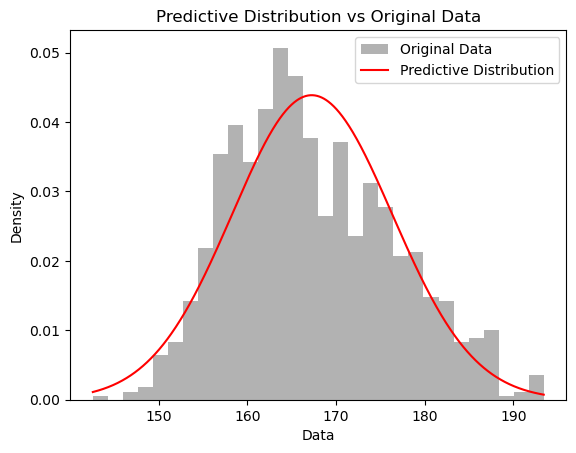

Iteration 800 completed! Time elapsed: 32.20s
Iteration 800, cluster_params: {0: {'mu': 167.3168863002626, 'kappa': 260182.5, 'alpha': 130092.0, 'beta': 10873821.832447551}, 1: {'mu': 167.3449841212165, 'kappa': 178823.5, 'alpha': 89412.5, 'beta': 7456064.950698013}, 2: {'mu': 167.36939137254942, 'kappa': 123486.5, 'alpha': 61744.0, 'beta': 5167347.595996497}, 3: {'mu': 167.34202483005606, 'kappa': 76291.5, 'alpha': 38146.5, 'beta': 3195438.261567349}, 4: {'mu': 167.39508971759707, 'kappa': 38027.5, 'alpha': 19014.5, 'beta': 1594017.7894303163}, 5: {'mu': 167.31768114580248, 'kappa': 18399.5, 'alpha': 9200.5, 'beta': 762170.294004796}, 6: {'mu': 167.35027700719704, 'kappa': 335.5, 'alpha': 168.5, 'beta': 12542.322242475811}, 7: {'mu': 167.68215855062047, 'kappa': 254.5, 'alpha': 128.0, 'beta': 10516.389007654618}}


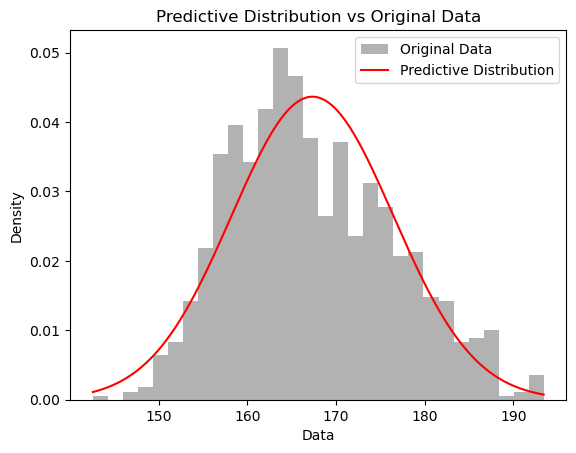

Iteration 900 completed! Time elapsed: 36.20s
Iteration 900, cluster_params: {0: {'mu': 167.31335801198836, 'kappa': 291729.5, 'alpha': 145865.5, 'beta': 12199180.303855501}, 1: {'mu': 167.34336716121425, 'kappa': 198005.5, 'alpha': 99003.5, 'beta': 8255517.86841815}, 2: {'mu': 167.3630115092293, 'kappa': 138109.5, 'alpha': 69055.5, 'beta': 5769736.5234889425}, 3: {'mu': 167.35301921094674, 'kappa': 88743.5, 'alpha': 44372.5, 'beta': 3723476.920216372}, 4: {'mu': 167.38457657087503, 'kappa': 46282.5, 'alpha': 23142.0, 'beta': 1943655.0708607712}, 5: {'mu': 167.34676026532162, 'kappa': 23011.5, 'alpha': 11506.5, 'beta': 956846.8130526955}, 6: {'mu': 167.4130027714688, 'kappa': 3308.5, 'alpha': 1655.0, 'beta': 133206.21172116778}, 7: {'mu': 168.67008404733429, 'kappa': 122.5, 'alpha': 62.0, 'beta': 5383.6642040683655}, 8: {'mu': 165.95404758918076, 'kappa': 88.5, 'alpha': 45.0, 'beta': 2712.853799314124}, 9: {'mu': 167.11094458821984, 'kappa': 84.5, 'alpha': 43.0, 'beta': 3856.3321796843

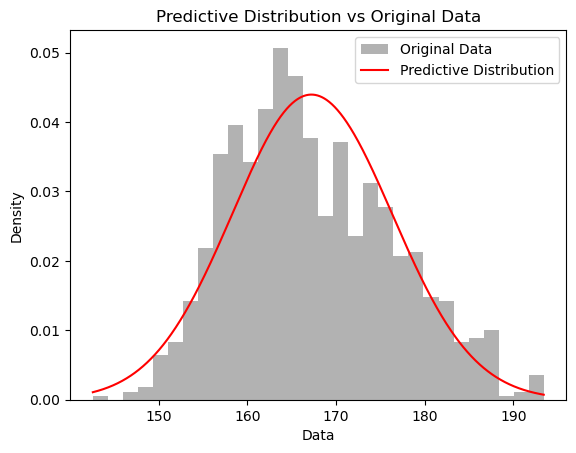

Iteration 1000 completed! Time elapsed: 40.29s
Iteration 1000, cluster_params: {0: {'mu': 167.31547554946005, 'kappa': 325553.5, 'alpha': 162777.5, 'beta': 13619726.779912278}, 1: {'mu': 167.34406537501053, 'kappa': 220500.5, 'alpha': 110251.0, 'beta': 9197021.61651279}, 2: {'mu': 167.35318783823487, 'kappa': 153391.5, 'alpha': 76696.5, 'beta': 6409030.982522491}, 3: {'mu': 167.35132013787398, 'kappa': 99357.5, 'alpha': 49679.5, 'beta': 4165817.1417318895}, 4: {'mu': 167.48490097907037, 'kappa': 4115.5, 'alpha': 2058.5, 'beta': 175024.945973469}, 5: {'mu': 167.48858159619198, 'kappa': 3205.5, 'alpha': 1603.5, 'beta': 131116.22574795026}, 6: {'mu': 167.39151791373067, 'kappa': 1402.5, 'alpha': 702.0, 'beta': 60333.9332441602}, 7: {'mu': 167.26650946812, 'kappa': 1216.5, 'alpha': 609.0, 'beta': 49061.79803595859}, 8: {'mu': 167.2704632262208, 'kappa': 270.5, 'alpha': 136.0, 'beta': 12036.54530538705}, 9: {'mu': 168.72471970652393, 'kappa': 8.5, 'alpha': 5.0, 'beta': 176.3982395197339}, 1

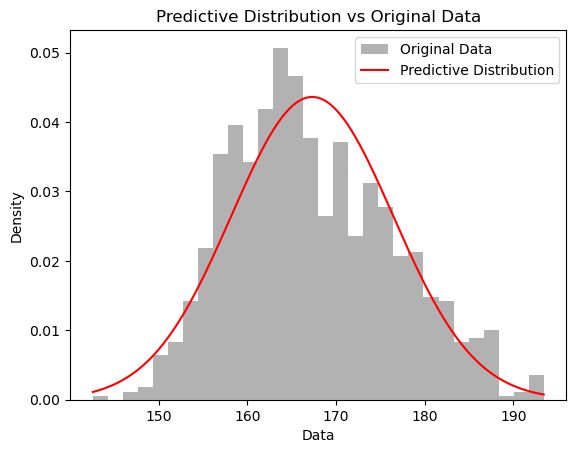

In [19]:
def plot_predictive_distribution(data, cluster_params, assignments, bins=30):
    # Calculate cluster proportions
    n_data = len(data)
    cluster_ids, counts = np.unique(assignments, return_counts=True)
    proportions = counts / n_data

    # Generate predictive distribution
    x_vals = np.linspace(min(data), max(data), 1000)
    predictive_pdf = np.zeros_like(x_vals)
    for cluster_id, proportion in zip(cluster_ids, proportions):
        params = cluster_params[cluster_id]
        mu, sigma = params['mu'], np.sqrt(params['beta'] / (params['alpha'] - 1))
        predictive_pdf += proportion * norm.pdf(x_vals, loc=mu, scale=sigma)

    # Plot histogram of data
    plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray', label='Original Data')

    # Plot predictive distribution
    plt.plot(x_vals, predictive_pdf, label='Predictive Distribution', color='red')

    plt.title('Predictive Distribution vs Original Data')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# setting
iterations = 1000
nsampling = 10
# alpha for dp
dp_alpha = 2

# Initialize cluster parameters 
default_params = {
    'mu': np.mean(data),
    'kappa': 0.5,
    'alpha': 1,
    'beta': 1
}

cluster_params = {0:default_params.copy()}

# history of P(z_i=k|x_i)
p1s = []
# history of P(mu_k, sigma_k|X_k)
params_history = []
n_data = len(data)

start_time = time.time()
for it in range(iterations):
    # length will be the length of data
    # if assignments = [0] means the first data point belongs to the first cluster
    assignments = np.zeros(n_data, dtype=np.int32)

    # for each cluster, sample and get weighted average of P(x_i|mu_k, sigma_k^2)
    # we assume the first data point belongs to cluster 0
    all_mus = {}
    all_sigmas = {}
    for k, k_params in cluster_params.items():
        sigma2_samples = invgamma.rvs(
            k_params['alpha'], 
            scale = k_params['beta'],
            size = nsampling
        )
        sigma_samples = np.sqrt(sigma2_samples)
        mu_samples = norm.rvs(
            k_params["mu"], 
            sigma_samples/np.sqrt(k_params['kappa'])
        )
        all_mus[k] = mu_samples
        all_sigmas[k] = sigma_samples

    for idx, d in enumerate(data):
        # Step 1: Calculate P(z_i = k | x_i) for all existing clusters
        p1 = np.zeros(len(cluster_params))
        for k_idx, k in enumerate(cluster_params.keys()):
            p1[k_idx] = calculate_log_likelihood(d, all_mus[k], all_sigmas[k])
        
        # Step 2: Assign data point to a cluster
        if idx == 0:
            assignments[idx] = 0
            continue

        curr_assignments = assignments[:idx] # excluding assignments[idx]
        choices = np.arange(0, max(curr_assignments) + 2)
        n_k = np.bincount(curr_assignments)
        curr_total = idx + dp_alpha
        probs = np.append(n_k/curr_total, dp_alpha/curr_total)
        cluster_assigned = np.random.choice(choices, p = probs)
        assignments[idx] = cluster_assigned

        # if cluster is new, initiate params for this cluster
        if cluster_assigned not in cluster_params:
            cluster_params[cluster_assigned] = default_params.copy()
            sigma2_samples = invgamma.rvs(
                default_params['alpha'], 
                scale = default_params['beta'],
                size = nsampling
            )
            sigma_samples = np.sqrt(sigma2_samples)
            mu_samples = norm.rvs(
                default_params["mu"], 
                sigma_samples/np.sqrt(default_params['kappa'])
            )
            all_mus[cluster_assigned] = mu_samples
            all_sigmas[cluster_assigned] = sigma_samples

    
    # Remove empty clusters from cluster_params
    empty_k = [x for x in cluster_params.keys() if x not in np.unique(assignments)]
    for k in empty_k:
        del cluster_params[k]

    # Step 3: Batch update cluster parameters of P(mu_k, sigma_k^2|X_k)
    for k, k_params in cluster_params.items():
        cluster_data = data[assignments == k]
        n = len(cluster_data)

        if n> 0:
            x_bar = np.mean(cluster_data)

            kappa_n = k_params['kappa'] + n
            mu_n = (k_params['kappa'] * k_params['mu'] + n * x_bar) / kappa_n
            alpha_n = k_params['alpha'] + 0.5 * n
            beta_n = k_params['beta'] + 0.5 * np.sum((cluster_data - x_bar)**2) + (
                k_params['kappa'] * n * (x_bar - k_params['mu'])**2) / (2 * kappa_n)
                
            cluster_params[k] = {
                'mu': mu_n,
                "kappa": kappa_n,
                "alpha": alpha_n,
                "beta": beta_n
            }
        
    # keep data from this iteration 
    if (it + 1) % 100 == 0:
        elapsed = time.time() - start_time
        print(f"Iteration {it+1} completed! Time elapsed: {elapsed:.2f}s")
        print(f"Iteration {it+1}, cluster_params: {cluster_params}")
        plot_predictive_distribution(data, cluster_params, assignments)
    p1s.append(list(p1))
    params_history.append({k: v.copy() for k, v in cluster_params.items()})

In [15]:
#|code-fold:true

def visualize_dpmm_results(data, assignments, params, p1s):
    """
    Comprehensive visualization of DPMM results.
    
    Args:
        data: Original data points
        assignments: Final cluster assignments
        params: History of cluster parameters
        p1s: History of likelihoods
    """
    plot_cluster_sizes(assignments)
    
    plot_mu_evolution(params)
    plot_sigma_evolution(params)

    plot_likelihood_progression(p1s)

    plt.show()

def plot_cluster_sizes(assignments, ax=None):
    """Plot the distribution of cluster sizes."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_clusters, counts = np.unique(assignments, return_counts=True)
    ax.bar(unique_clusters, counts, alpha=0.8, color='skyblue')
    ax.set_title('Cluster Sizes')
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('Number of Data Points')
    ax.grid(True, alpha=0.3)

def plot_mu_evolution(params_history, ax=None):
    """Plot the evolution of mu (mean) over iterations."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Track mean parameters for each cluster
    cluster_means = {}
    total_iterations = len(params_history)
    
    for i, params in enumerate(params_history):
        for cluster_id in params.keys():  # Use actual cluster IDs
            if cluster_id not in cluster_means:
                cluster_means[cluster_id] = [None] * total_iterations  # Pre-fill with None
            cluster_means[cluster_id][i] = params[cluster_id]['mu']
    
    # Plot mean evolution for each cluster
    for cluster_id, means in cluster_means.items():
        iterations = range(total_iterations)
        ax.plot(iterations, means, '-o', label=f'Cluster {cluster_id}', markersize=3)
    
    ax.set_title('Evolution of Cluster Means')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Mean Value (μ)')
    ax.grid(True, alpha=0.3)
    ax.legend()

def plot_sigma_evolution(params_history, ax=None):
    """
    Plot the evolution of cluster standard deviations (σ) over iterations.
    
    Args:
        params_history (list): List of dictionaries with cluster parameters for each iteration.
        ax (matplotlib.axes.Axes, optional): Matplotlib axis object for plotting.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Track standard deviation (sigma) for each cluster
    cluster_sigmas = {}
    total_iterations = len(params_history)
    
    for i, params in enumerate(params_history):
        for cluster_id in params.keys():  # Use actual cluster IDs
            if cluster_id not in cluster_sigmas:
                cluster_sigmas[cluster_id] = [None] * total_iterations  # Pre-fill with None
            beta_k = params[cluster_id]['beta']
            alpha_k = params[cluster_id]['alpha']
            sigma_k = np.sqrt(beta_k / alpha_k)  # Compute standard deviation
            cluster_sigmas[cluster_id][i] = sigma_k
    
    # Plot sigma evolution for each cluster
    for cluster_id, sigmas in cluster_sigmas.items():
        iterations = range(total_iterations)
        ax.plot(iterations, sigmas, '-o', label=f'Cluster {cluster_id}', markersize=3)
    
    ax.set_title('Evolution of Cluster Standard Deviations (σ)')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Standard Deviation (σ)')
    ax.grid(True, alpha=0.3)
    ax.legend()

def plot_likelihood_progression(p1s, ax=None):
    """Plot the progression of average likelihood."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate average likelihood for each iteration
    avg_likelihoods = [np.mean(p1) for p1 in p1s]
    iterations = range(len(avg_likelihoods))
    
    ax.plot(iterations, avg_likelihoods, '-o', markersize=3)
    ax.set_title('Average Likelihood Progression')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Average Likelihood')
    ax.grid(True, alpha=0.3)

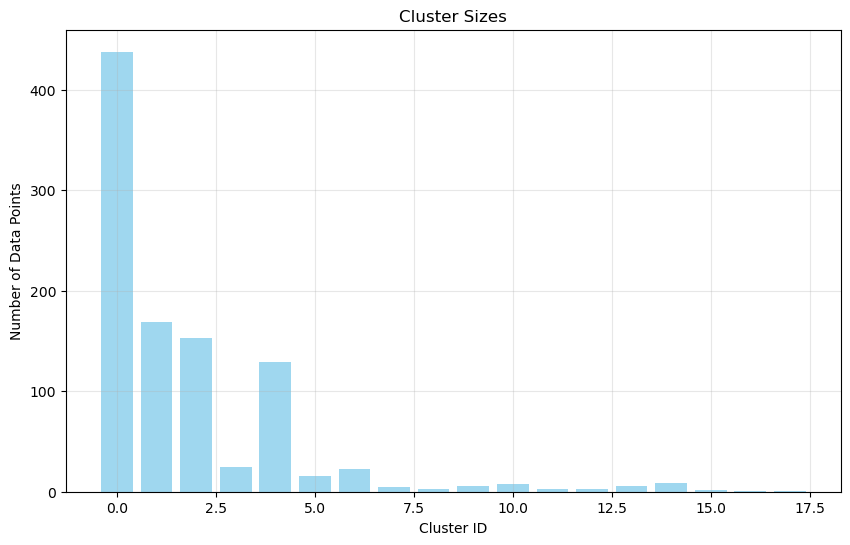

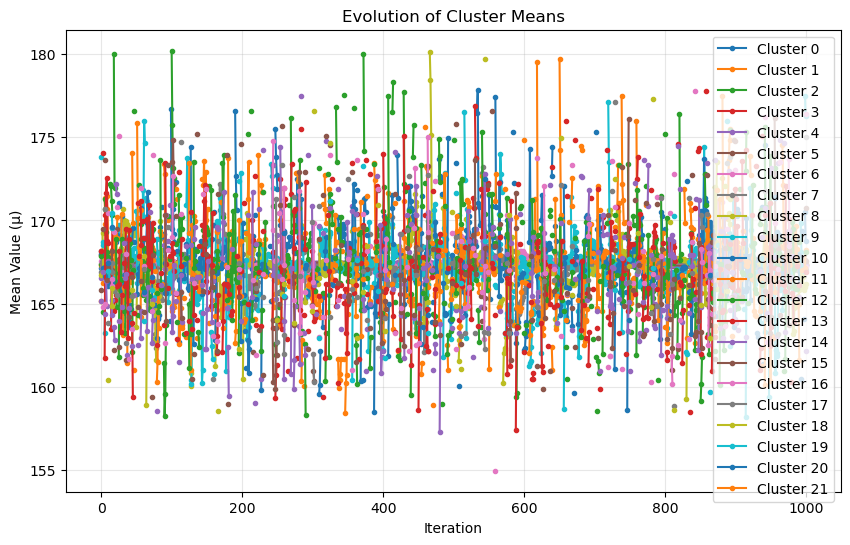

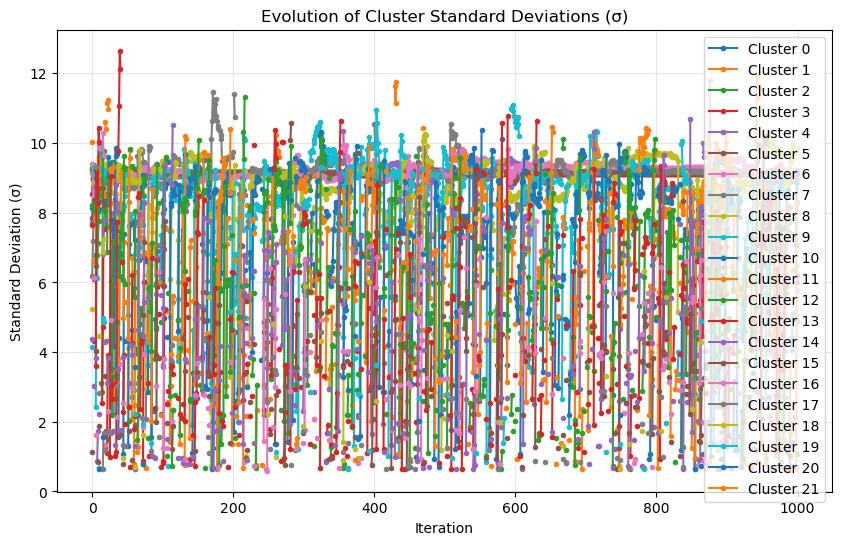

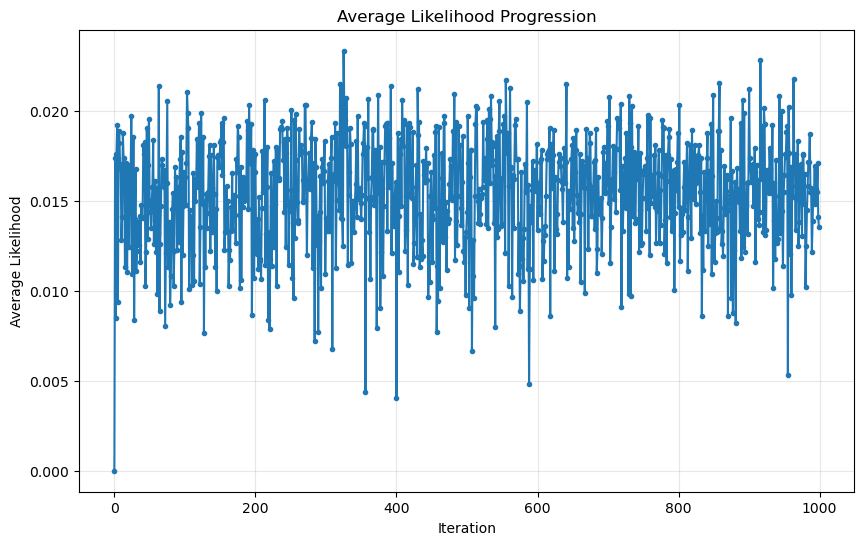

In [16]:
# Create all visualizations at once
visualize_dpmm_results(data, assignments, params_history, p1s)